# 2. Physics Informed Neural Networks  
use pinn to analyse ro equation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.optim as optim

In [20]:
# device = torch.device('cuda:0')

# 2-1. Initial Value Problem (ODE)

We will solve a simple system of ODEs 
$\begin{equation}
\frac{dy_1}{dt} = y_2, \quad  \frac{dy_2}{dt} = -y_1, \quad \text{for  } t \in [0,10],
\end{equation} $ with $ \begin{equation}
y_1(0) = 0, \quad y_2(0)=1.
\end{equation} $ Then, the solutions are given by 
$\begin{equation}
y_1(t) = \sin(t), \quad y_2(t) = \cos(t).
\end{equation}$

# Dataset generation

In [2]:
N = 100                                                   # Number of samples
t = torch.linspace(0, 10, N).view(-1,1)                  # Input data (N x 1)
t_init = torch.zeros([1,1])                               # Input data the initial conditions (1 x 1)
y_init = torch.FloatTensor([[0,1]])   #(y1,y2)                    # Target data the initial conditions (1 x 2)
y_true = torch.cat([torch.sin(t), torch.cos(t)], dim=1)   # True solutions (N x 2)
print(len(t))

100


# Neural Network

In [3]:
# Build a neural network

class model(nn.Module) :
    def __init__(self, hidden_dims) :                    # Hidden_dims : [h1, h2, h3, ..., hn]
        super(model, self).__init__()
        
        self.layers = []
        for i in range(len(hidden_dims)-1) :
            self.layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1])) # hidden layers
        self.layers = nn.ModuleList(self.layers)
        
        for layer in self.layers :                       # Weight initialization
            nn.init.xavier_uniform_(layer.weight)        # Also known as Glorot initialization

        self.act = nn.Tanh()                             # Nonlinear activation function
    
    def forward(self, x) :
        for layer in self.layers[:-1] :
            x = self.act(layer(x))
        x = self.layers[-1](x)
        return x

# Loss function, Optimizer

In [8]:
# Prepare for training
'''
network = model(hidden_dims=[1,64,64,2]).to(device)   # Pass the network to GPU
t = t.to(device).requires_grad_(True)                 # Pass data to GPU
t_init = t_init.to(device)                            # Pass data to GPU
y_init = y_init.to(device)                            # Pass data to GPU
y_true = y_true.to(device)                            # Pass data to GPU
'''
network = model(hidden_dims=[1,64,64,2])   # Pass the network to GPU
t = t.requires_grad_(True)                 # Pass data to GPU
t_init = t_init                           # Pass data to GPU
y_init = y_init                            # Pass data to GPU
y_true = y_true                         # Pass data to GPU

loss_f = nn.MSELoss()                                 # Mean Square Error loss function
optimizer = optim.Adam(network.parameters(), lr=1e-3) # Adam optimizer
EPOCHS = 20000                                        # Number of Training Iterations

# Compute $\frac{dy}{dt}$

In [5]:
def derivative(y, t) : 
    '''
    return torch.autograd.grad(y, t, create_graph=True,\
                               grad_outputs=torch.ones(y.size()).to(device))[0]
    '''
    return torch.autograd.grad(y, t, create_graph=True,\
                            grad_outputs=torch.ones(y.size()))[0]

# Training

In [9]:
# Train
loss_list = []
#network.train()
#전구간의 t를 주지말고, random sampling해서 t를 뽑아 학습(train)시키는건?
#train_t = (np.random.rand(30)*2).reshape(-1,1)
#test에서는 전구간 t에 대해 하고
for i in range(EPOCHS) :
    optimizer.zero_grad()
    #print(t)
    output = network(t) #(y1,y2) for total t
    output_init = network(t_init) #(y1,y2) for initial t
    #print(output)
    dy1 = derivative(output[:,0], t)
    dy2 = derivative(output[:,1], t) 
    #print(output[:,0])
    #print(dy1)
    #print(torch.zeros_like(dy1))

    loss_init = loss_f(output_init, y_init) #(y1,y2) #y초깃값하고 비교(initial condition)
    loss_ge = loss_f(dy1 - output[:,1].view(-1,1), torch.zeros_like(dy1)) \
            + loss_f(dy2 + output[:,0].view(-1,1), torch.zeros_like(dy1))
    loss = loss_init + loss_ge
    loss.backward()
    optimizer.step()
    
    loss_list.append(loss.item())
    if not i % 100 :
        print('EPOCH : %6d/%6d | Loss_init : %8.7f | Loss_ge : %8.7f ' %(i, EPOCHS, loss_init.item(), loss_ge.item()))
        clear_output(wait=True)
print('Training Finished.')

Training Finished.


In [20]:
torch.save([network, loss_list], 'forward_ode.pt')
#network, loss_list = torch.load('forward_ode.pt')

# Plot Results

Mean Square Error for $y_1(t)$ : 0.0000050
Mean Square Error for $y_2(t)$ : 0.0000044


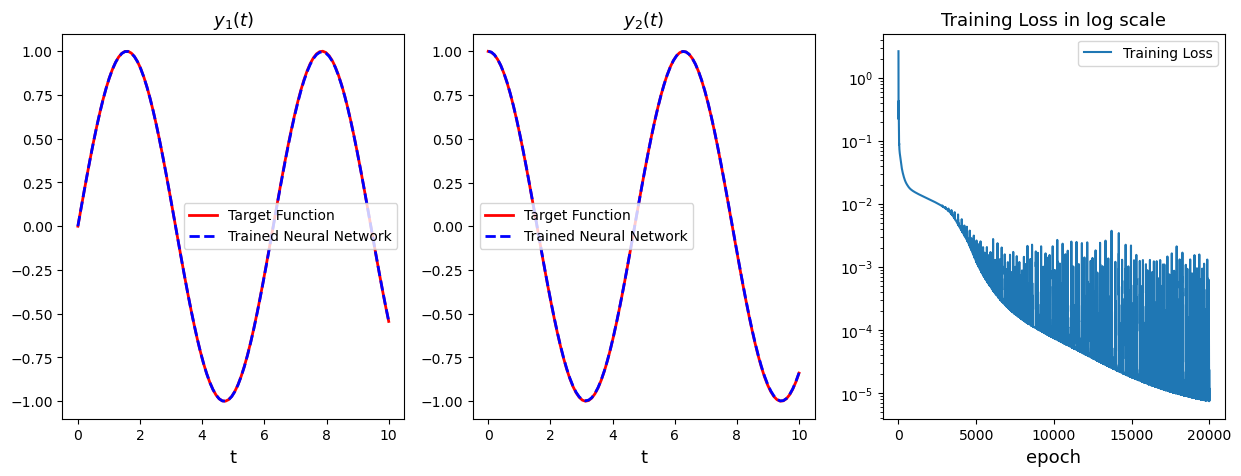

In [10]:
print('Mean Square Error for $y_1(t)$ : %8.7f' %((network(t)[:,0].view(-1,1) - torch.sin(t))**2).mean())
print('Mean Square Error for $y_2(t)$ : %8.7f' %((network(t)[:,1].view(-1,1) - torch.cos(t))**2).mean())

#network.eval()
figure = plt.figure(figsize=(15,5))
ax1 = figure.add_subplot(1,3,1)
ax1.plot(t.cpu().detach().numpy(), torch.sin(t).cpu().detach().numpy(),\
         linestyle='-', lw=2, color='r', label='Target Function')
ax1.plot(t.cpu().detach().numpy(), network(t).cpu().detach().numpy()[:,0],\
         linestyle='--', lw=2, color='b', label='Trained Neural Network')
ax1.legend()
ax1.set_title('$y_1(t)$', fontsize=13)
ax1.set_xlabel('t', fontsize=13)

ax2 = figure.add_subplot(1,3,2)
ax2.plot(t.cpu().detach().numpy(), torch.cos(t).cpu().detach().numpy(),\
         linestyle='-', lw=2, color='r', label='Target Function')
ax2.plot(t.cpu().detach().numpy(), network(t).cpu().detach().numpy()[:,1],\
         linestyle='--', lw=2, color='b', label='Trained Neural Network')
ax2.legend()
ax2.set_title('$y_2(t)$', fontsize=13)
ax2.set_xlabel('t', fontsize=13)

ax3 = figure.add_subplot(1,3,3)
ax3.plot(loss_list, label='Training Loss')
ax3.set_yscale('log')
ax3.legend()
ax3.set_title('Training Loss in log scale', fontsize=13)
ax3.set_xlabel('epoch', fontsize=13)

plt.savefig('ode', dpi=100)

# 2-2. Initial Boundary Value Problem (PDE)

We will solve the Burgers equation : 
$ \begin{equation}
\partial_t u + u\partial_x u = \nu \partial_{xx} u, \text{ for } (t,x) \in [0,1]\times[-1,1],
\end{equation} $
with the Dirichlet boundary conditions 
$ \begin{equation}
u(t,-1) = u(t,1) = 0, \text{ for } t \in [0,1],
\end{equation} $
and an initial condition 
$ \begin{equation} u(0, x) = -\sin(\pi x). \end{equation} $

# Dataset generation

In [10]:
Nt = 50                                                   # Number of samples
Nx = 50                                                   # Number of samples
t = torch.linspace(0, 1, Nt)                              # Input data for t (N x 1)
x = torch.linspace(-1, 1, Nx)                             # Input data for x (N x 1)

tx = torch.meshgrid(t,x)
tx_grid = torch.cat([tx[0].reshape(-1,1), tx[1].reshape(-1,1)],dim=1)

x_init = tx_grid[tx_grid[:,0]==0]
u_init = -torch.sin(np.pi*x_init[:,1]).view(-1,1)
x_bdry = tx_grid[torch.logical_or((tx_grid[:,1]==1), (tx_grid[:,1]==-1))]
u_bdry = torch.zeros_like(x_bdry[:,0].view(-1,1))

/opt/ohpc/pub/python/3.11.2/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


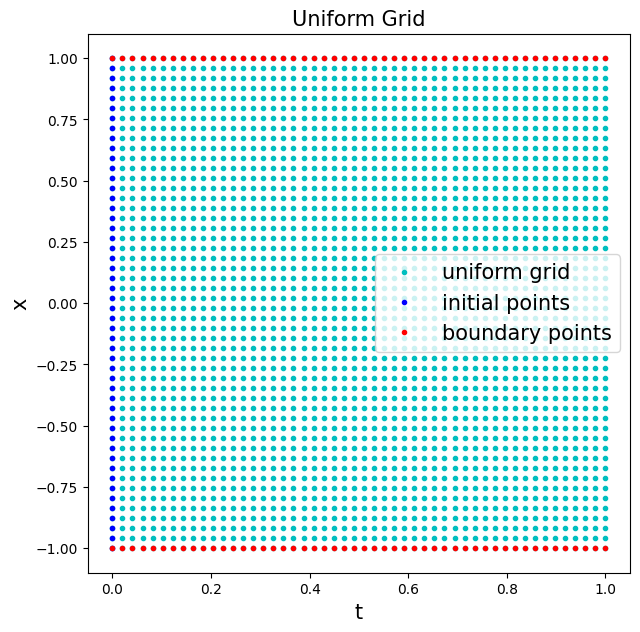

In [11]:
plt.figure(figsize=(7,7))
plt.plot(tx_grid[:,0], tx_grid[:,1], 'co', markersize=3, label='uniform grid')
plt.plot(x_init[:,0], x_init[:,1], 'bo', markersize=3, label='initial points')
plt.plot(x_bdry[:,0], x_bdry[:,1], 'ro', markersize=3, label='boundary points')
plt.legend(loc='center right', fontsize=15)
plt.title('Uniform Grid', fontsize=15)
plt.xlabel('t', fontsize=15)
plt.ylabel('x', fontsize=15)
plt.savefig('burgers_data', dpi=100)

# Neural Network

In [12]:
# Build a neural network

class model(nn.Module) :
    def __init__(self, hidden_dims) :                    # Hidden_dims : [h1, h2, h3, ..., hn]
        super(model, self).__init__()
        
        self.layers = []
        for i in range(len(hidden_dims)-1) :
            self.layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1])) # hidden layers
        self.layers = nn.ModuleList(self.layers)
        
        for layer in self.layers :                       # Weight initialization
            nn.init.xavier_uniform_(layer.weight)        # Also known as Glorot initialization

        self.act = nn.Tanh()                             # Nonlinear activation function
    
    def forward(self, x) :
        for layer in self.layers[:-1] :
            x = self.act(layer(x))
        x = self.layers[-1](x)
        return x

# Loss function, Optimizer

In [13]:
# Prepare for training

network = model(hidden_dims=[2,64,64,64,64,1]).to(device)       # Pass the network to GPU
tx_grid = tx_grid.to(device).requires_grad_(True)               # Pass data to GPU
x_init = x_init.to(device)                             # Pass data to GPU
u_init = u_init.to(device)                             # Pass data to GPU
x_bdry = x_bdry.to(device)                             # Pass data to GPU
u_bdry = u_bdry.to(device)                             # Pass data to GPU

loss_f = nn.MSELoss()                                  # Mean Square Error loss function
optimizer = optim.Adam(network.parameters(), lr=1e-4)  # Adam optimizer
EPOCHS = 20000                                         # Number of Training Iterations

# Compute $\frac{\partial u}{\partial t}, \frac{\partial u}{\partial x}$

In [14]:
def derivative(y, x) : 
    return torch.autograd.grad(y, x, create_graph=True,\
                               grad_outputs=torch.ones(y.size()).to(device))[0]

# Training

In [15]:
# Train
loss_list = []
network.train()

for i in range(1, EPOCHS+1) :
    optimizer.zero_grad()
    output = network(tx_grid)
    output_init = network(x_init)
    output_bdry = network(x_bdry)
    
    grad_output = derivative(output, tx_grid)  # \nabla_{t,x} u
    output_t = grad_output[:,0].view(-1,1)
    output_x = grad_output[:,1].view(-1,1)
    output_xx = derivative(grad_output[:,1], tx_grid)[:,1].view(-1,1)
    
    loss_init = loss_f(output_init, u_init)
    loss_bdry = loss_f(output_bdry, u_bdry)
    loss_ge = loss_f(output_t + output*output_x - (0.01/np.pi)*output_xx, torch.zeros_like(output))
    
    loss = loss_ge + loss_init + loss_bdry
    loss.backward()
    optimizer.step()
    
    loss_list.append(loss.item())
    if not i % 100 :
        print('EPOCH : %6d/%6d | Loss_ge : %8.7f | Loss_init : %8.7f | Loss_bdry : %8.7f' \
              %(i, EPOCHS, loss_ge.item(), loss_init.item(), loss_bdry.item()))
        clear_output(wait=True)
print('Training Finished.')

Training Finished.


In [16]:
torch.save([network, loss_list], 'forward_Burgers.pt')
#network, loss_list = torch.load('forward_Burgers.pt')

# Plot Results

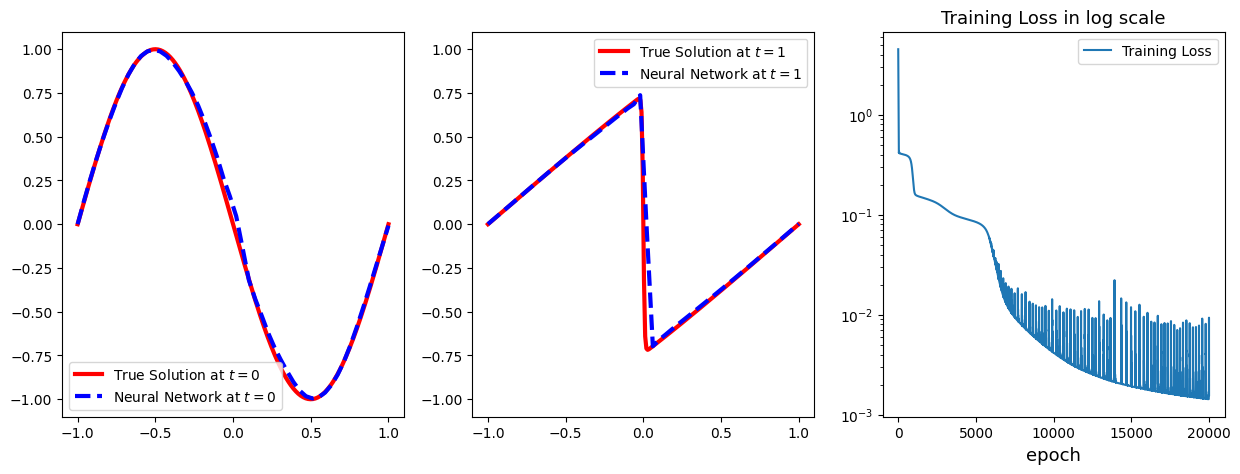

In [17]:
data = np.load('Burgers.npz')

figure = plt.figure(figsize=(15,5))
ax1 = figure.add_subplot(1,3,1)
ax1.plot(np.linspace(-1,1,256), data['usol'][:,0],\
         label='True Solution at $t=0$', linestyle='-', lw=3, color='r')
ax1.plot(x_init[:,1].cpu(), network(x_init).cpu().detach(),\
         label='Neural Network at $t=0$', linestyle='--', lw=3, color='b')
ax1.legend()

ax2 = figure.add_subplot(1,3,2)
ax2.plot(np.linspace(-1,1,256), data['usol'][:,-1],\
         label='True Solution at $t=1$', linestyle='-', lw=3, color='r')
ax2.plot(tx_grid[tx_grid[:,0]==1][:,1].cpu().detach(), network(tx_grid[tx_grid[:,0]==1]).cpu().detach(),\
         label='Neural Network at $t=1$', linestyle='--', lw=3, color='b')
ax2.legend(loc='upper right', fontsize=10)
ax2.set_ylim(-1.1,1.1)

ax3 = figure.add_subplot(1,3,3)
ax3.plot(loss_list, label='Training Loss')
ax3.set_yscale('log')
ax3.legend()
ax3.set_title('Training Loss in log scale', fontsize=13)
ax3.set_xlabel('epoch', fontsize=13)
plt.savefig('burgers', dpi=100)

# 2-3. Inverse problem for the Lorenz system

 We will solve the Lorentz system : 
$ \begin{equation}
\frac{dx}{dt} = \sigma(y-x),\quad \frac{dy}{dt} = x(\rho-z)-y,\quad \frac{dz}{dt} = xy - \beta z, \quad \text{for } t\in [0,3]
\end{equation} $
with initial conditions 
$ \begin{equation}
x(0)=-8, \quad y(0)=7, \quad z(0)=27.
\end{equation} $
The parameters $\sigma=10, \rho=15, \beta=\frac{8}{3}$ will be identified from observations of the system.

# Dataset generation

In [37]:
N = 100                                                  # Number of samples
t = torch.linspace(0, 3, N).view(-1,1)                   # Input data (N x 1)
t_init = torch.zeros([1,1])                              # Input data the initial conditions (1 x 1)
y_init = torch.FloatTensor([[-8, 7, 27]])                # Target data the initial conditions (1 x 2)

# Observations

In [40]:
import numpy as np
data = np.load('Lorenz.npz')

FileNotFoundError: [Errno 2] No such file or directory: 'Lorenz.npz'

In [20]:
t_obs = torch.FloatTensor(data['t'])
y_obs = torch.FloatTensor(data['y'])

print(y_obs)

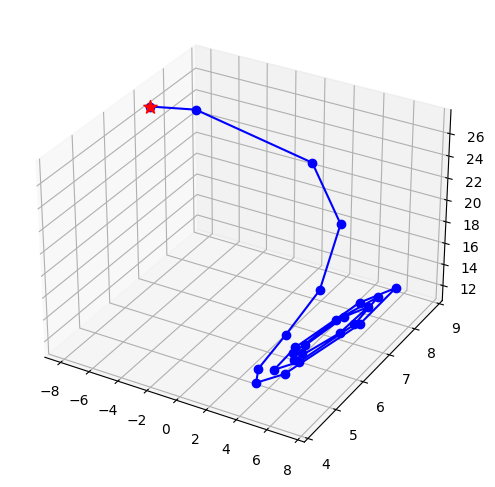

In [21]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(-8,7,27, marker='*', s=100, color='r')
ax.plot(data['y'][:,0],data['y'][:,1],data['y'][:,2], 'b')
ax.plot(data['y'][:,0],data['y'][:,1],data['y'][:,2], 'bo')
plt.savefig('lorenz_data', dpi=100)

# Neural Network

In [22]:
# Build a neural network

class model(nn.Module) :
    def __init__(self, hidden_dims) :                    # Hidden_dims : [h1, h2, h3, ..., hn]
        super(model, self).__init__()
        
        self.layers = []
        for i in range(len(hidden_dims)-1) :
            self.layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1])) # hidden layers
        self.layers = nn.ModuleList(self.layers)
        
        for layer in self.layers :                       # Weight initialization
            nn.init.xavier_uniform_(layer.weight)        # Also known as Glorot initialization

        self.act = nn.Tanh()                             # Nonlinear activation function
    
    def forward(self, x) :
        for layer in self.layers[:-1] :
            x = self.act(layer(x))
        x = self.layers[-1](x)
        return x

# Loss function, Optimizer, Additional Parameters

In [23]:
# Prepare for training

network = model(hidden_dims=[1,64,64,64,3]).to(device) # Pass the network to GPU
t = t.to(device).requires_grad_(True)                 # Pass data to GPU
t_init = t_init.to(device)                            # Pass data to GPU
y_init = y_init.to(device)                            # Pass data to GPU
t_obs = t_obs.to(device)                              # Pass data to GPU                            
y_obs = y_obs.to(device)                              # Pass data to GPU
 
sigma = torch.ones(1).to(device).requires_grad_(True)            # Parameter approximator
rho = torch.ones(1).to(device).requires_grad_(True)              # Parameter approximator
beta = torch.ones(1).to(device).requires_grad_(True)             # Parameter approximator

loss_f = nn.MSELoss()                                            # Mean Square Error loss function
optimizer = optim.Adam([{'params': network.parameters()},\
                        {'params': sigma, 'lr':1e-1}, {'params': rho, 'lr':1e-1},\
                        {'params': beta, 'lr':1e-1}], lr=1e-3)              # Adam optimizer
EPOCHS = 100000                                                   # Number of Training Iterations

# Compute $\frac{dy}{dt}$

In [24]:
def derivative(y, t) : 
    return torch.autograd.grad(y, t, create_graph=True,\
                               grad_outputs=torch.ones(y.size()).to(device))[0]

In [25]:
# Train
loss_list = []
sigma_list, rho_list, beta_list = [], [], []
network.train()

for i in range(1, EPOCHS+1) :
    optimizer.zero_grad()
    output = network(t)
    output_init = network(t_init)
    output_obs = network(t_obs)
    
    dy1 = derivative(output[:,0], t).view(-1) 
    dy2 = derivative(output[:,1], t).view(-1) 
    dy3 = derivative(output[:,2], t).view(-1) 
    
    loss_init = loss_f(output_init, y_init) 
    loss_obs = loss_f(output_obs, y_obs)
    loss_ge = loss_f(dy1 - sigma*(output[:,1]-output[:,0]), torch.zeros_like(dy1)) +\
                loss_f(dy2 - output[:,0]*(rho-output[:,2]) + output[:,1], torch.zeros_like(dy2))+\
                loss_f(dy3 - output[:,0]*output[:,1] + beta*output[:,2], torch.zeros_like(dy3))

    loss = loss_ge + loss_init + loss_obs
    loss.backward()
    optimizer.step()
    
    loss_list.append(loss.item())
    sigma_list.append(sigma.item())
    rho_list.append(rho.item())
    beta_list.append(beta.item())
    
    if not i % 1000 :
        print('EPOCH : %6d/%6d | Loss_ge : %8.7f | Loss_init : %8.7f | Loss_obs : %8.7f' \
              %(i, EPOCHS, loss_ge.item(), loss_init.item(), loss_obs.item()))
        clear_output(wait=True)
print('Training Finished.')

Training Finished.


In [26]:
torch.save([network, sigma_list, rho_list, beta_list], 'Lorenz.pt')
#network, sigma_list, rho_list, beta_list = torch.load('Lorenz.pt', map_location=device)

/opt/ohpc/pub/python/3.11.2/lib/python3.11/site-packages/mpl_toolkits/mplot3d/proj3d.py:210: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
/opt/ohpc/pub/python/3.11.2/lib/python3.11/site-packages/mpl_toolkits/mplot3d/proj3d.py:210: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([xs, ys, zs, np.ones_like(

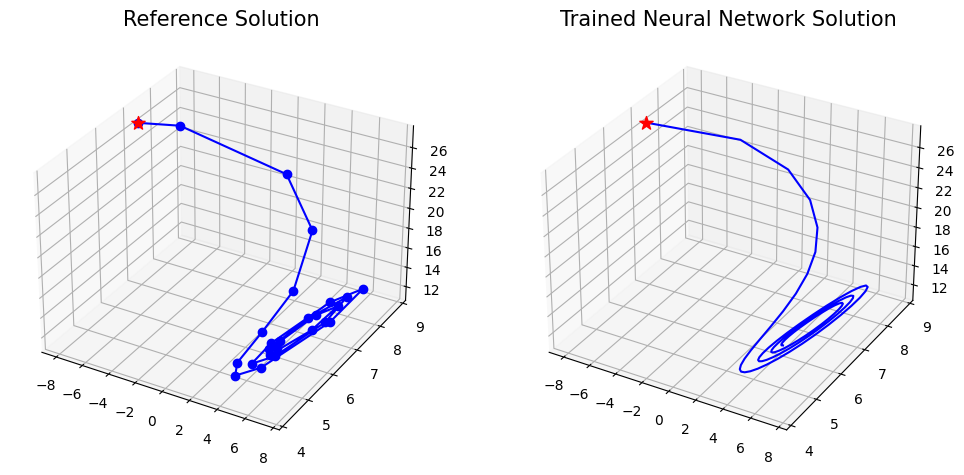

In [27]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(-8,7,27, marker='*', s=100, color='r')
ax.plot(data['y'][:,0], data['y'][:,1], data['y'][:,2], 'b')
ax.plot(data['y'][:,0], data['y'][:,1], data['y'][:,2], 'bo')
ax.set_title('Reference Solution', fontsize=15)

ax = fig.add_subplot(122, projection='3d')
ax.scatter(-8,7,27, marker='*', s=100, color='r')
prediction = network(t).cpu().detach()
ax.plot(prediction[:,0], prediction[:,1], prediction[:,2], 'b')
#ax.plot(prediction[:,0], prediction[:,1], prediction[:,2], 'bo')
ax.set_title('Trained Neural Network Solution', fontsize=15)
plt.savefig('lorenz', dpi=100)

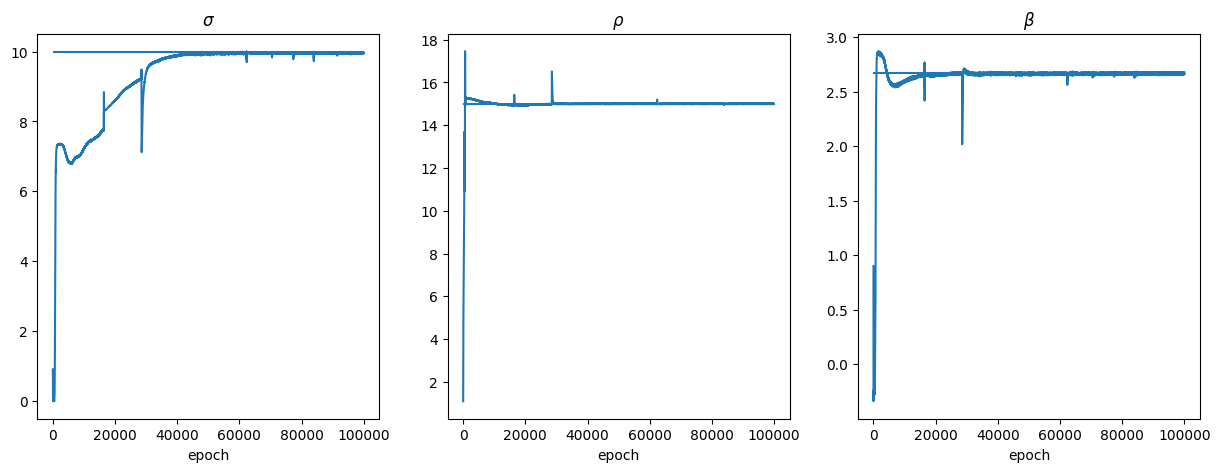

In [28]:
figure = plt.figure(figsize=(15,5))
ax1 = figure.add_subplot(1,3,1)
ax1.plot(sigma_list)
ax1.set_title('$\sigma$')
ax1.set_xlabel('epoch')
ax1.hlines(10, 0, 100000, label='True $\sigma$')

ax2 = figure.add_subplot(1,3,2)
ax2.plot(rho_list)
ax2.set_title('$\\rho$')
ax2.set_xlabel('epoch')
ax2.hlines(15, 0, 100000, label='True $\\rho$')

ax3 = figure.add_subplot(1,3,3)
ax3.plot(beta_list)
ax3.set_title('$\\beta$')
ax3.set_xlabel('epoch')
ax3.hlines(8/3, 0, 100000, label='True $\\beta$')
plt.savefig('lorenz2', dpi=100)

# 2-4. Inverse problem for the Poisson equation with unknown forcing field
 We will solve the Poisson equation : 
$ \begin{equation}
u_{xx} = q(x), \quad \text{ for } x \in [-1,1]
\end{equation} $
with the Dirichlet boundary conditions 
$ \begin{equation}
u(-1) = 0, \quad u(1) = 0.
\end{equation} $
Here, we assume both the solution $u(x)$ and the forcing term $q(x)$ are unknown. Instead, we assume that we are given a set of supervised observations $\{(x_i, u_i)\}_{i=1}^{100}$.

 The reference solution is $u(x)=\sin(\pi x)$, $q(x) = -\pi^2 \sin(\pi x)$.

# Dataset generation

In [29]:
N = 1000                                                 # Number of samples
x = torch.linspace(-1, 1, N).view(-1,1)                  # Input data (N x 1)
x_bdry = torch.FloatTensor([[-1],[1]])                   # Input data the initial conditions (1 x 1)
u_bdry = torch.zeros_like(x_bdry)                        # Target data the initial conditions (1 x 2)
x_obs = torch.linspace(-1, 1, 100).view(-1,1)            # Input data (N x 1)
u_obs = torch.sin(np.pi*x_obs)

# Neural Network

In [30]:
# Build a neural network

class model(nn.Module) :
    def __init__(self, hidden_dims) :                    # Hidden_dims : [h1, h2, h3, ..., hn]
        super(model, self).__init__()
        
        self.layers = []
        for i in range(len(hidden_dims)-1) :
            self.layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1])) # hidden layers
        self.layers = nn.ModuleList(self.layers)
        
        for layer in self.layers :                       # Weight initialization
            nn.init.xavier_uniform_(layer.weight)        # Also known as Glorot initialization

        self.act = nn.Tanh()                             # Nonlinear activation function
    
    def forward(self, x) :
        for layer in self.layers[:-1] :
            x = self.act(layer(x))
        x = self.layers[-1](x)
        return x

# Loss function, Optimizer, Additional Parameters

In [31]:
# Prepare for training

network_u = model(hidden_dims=[1,64,64,64,64,1]).to(device)   # Pass the network to GPU
network_q = model(hidden_dims=[1,64,64,64,64,1]).to(device)   # Pass the network to GPU

x = x.to(device).requires_grad_(True)                 # Pass data to GPU
x_bdry = x_bdry.to(device)                            # Pass data to GPU
u_bdry = u_bdry.to(device)                            # Pass data to GPU
x_obs = x_obs.to(device)                              # Pass data to GPU
u_obs = u_obs.to(device)                              # Pass data to GPU

loss_f = nn.MSELoss()                                             # Mean Square Error loss function
optimizer = optim.Adam([{'params': network_u.parameters()},\
                        {'params': network_q.parameters()},], lr=1e-4)              # Adam optimizer
EPOCHS = 100000                                                    # Number of Training Iterations

In [32]:
def derivative(y, t) : 
    return torch.autograd.grad(y, t, create_graph=True,\
                               grad_outputs=torch.ones(y.size()).to(device))[0]

# Training

In [33]:
# Train
loss_list = []
network_u.train()
network_q.train()

for i in range(1, EPOCHS+1) :
    optimizer.zero_grad()
    output_u, output_q = network_u(x), network_q(x)
    output_bdry = network_u(x_bdry)
    output_obs = network_u(x_obs)
    
    doutput = derivative(output_u, x)
    d2output = derivative(doutput, x)
    
    loss_bdry = loss_f(output_bdry, u_bdry) 
    loss_obs = loss_f(output_obs, u_obs)
    loss_ge = loss_f(d2output-output_q, torch.zeros_like(output_q))
    
    loss = loss_ge + loss_bdry + loss_obs
    loss.backward()
    optimizer.step()
    
    loss_list.append(loss.item())
    
    if not i % 1000 :
        print('EPOCH : %6d/%6d | Loss_ge : %8.7f | Loss_bdry : %8.7f | Loss_obs : %8.7f' \
              %(i, EPOCHS, loss_ge.item(), loss_bdry.item(), loss_obs.item()))
        clear_output(wait=True)
print('Training Finished.')

Training Finished.


In [34]:
torch.save([network_u, network_q], 'Poisson_inverse.pt')
#network_u, network_q = torch.load('Poisson_inverse.pt', map_location=device)

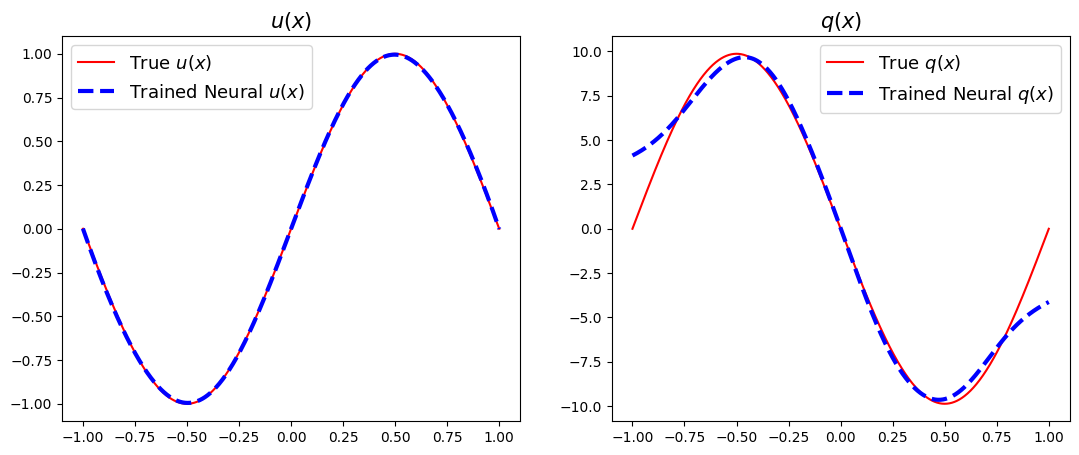

In [35]:
figure = plt.figure(figsize=(13,5))
ax1 = figure.add_subplot(1,2,1)
ax1.plot(x.cpu().detach(), torch.sin(np.pi * x).cpu().detach(), color='r', label='True $u(x)$')
ax1.plot(x.cpu().detach(), network_u(x).cpu().detach(), color='b', linestyle='--', lw=3, label='Trained Neural $u(x)$')
ax1.legend(fontsize=13)
ax1.set_title('$u(x)$', fontsize=15)

ax2 = figure.add_subplot(1,2,2)
ax2.plot(x.cpu().detach(), -(np.pi**2)*torch.sin(np.pi * x).cpu().detach(), color='r', label='True $q(x)$')
ax2.plot(x.cpu().detach(), network_q(x).cpu().detach(), color='b', linestyle='--', lw=3, label='Trained Neural $q(x)$')
ax2.legend(fontsize=13)
ax2.set_title('$q(x)$', fontsize=15)
plt.savefig('poisson_inv', dpi=100)